# 🤖 Advanced Tutorial: Full ML Backtest Simulation

This notebook demonstrates the *core* functionality of the `RiskLabAI` library: running a full-scale backtest overfitting simulation.

Unlike the conceptual demo, this workflow uses the `overall_backtest_overfitting_simulation` function. This function orchestrates the entire process:

1.  **Feature Engineering:** Creates features from prices (FracDiff, Volatility, TA-Lib).
2.  **Labeling:** Generates CUSUM events, triple barriers, and meta-labels.
3.  **Strategy Generation:** Runs multiple strategy parameter combinations (e.g., different moving average windows).
4.  **Model Training:** Trains multiple ML models with hyperparameter grids.
5.  **Cross-Validation:** Backtests every combination using all specified CV methods ('Walk-Forward', 'K-Fold', 'Purged K-Fold', 'Combinatorial Purged').
6.  **Analysis:** Calculates the final Probability of Backtest Overfitting (PBO) and Deflated Sharpe Ratio (DSR) for each CV method.

## 0. Setup and Imports

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import warnings

# ML Model Import
from sklearn.linear_model import LogisticRegression

# RiskLabAI Imports
# Note: This is the main simulation engine, not used in the other notebook
from RiskLabAI.backtest import (
    overall_backtest_overfitting_simulation
)

# Setup plotting and configuration
warnings.filterwarnings('ignore')

## 1. Create Dummy Price Data

The simulation functions are data-intensive. We need a sufficiently long price series to generate enough events for labeling and cross-validation.

We'll create a 5,000-step (e.g., ~20 years of daily data) random walk.

Created dummy price series with 5000 steps.


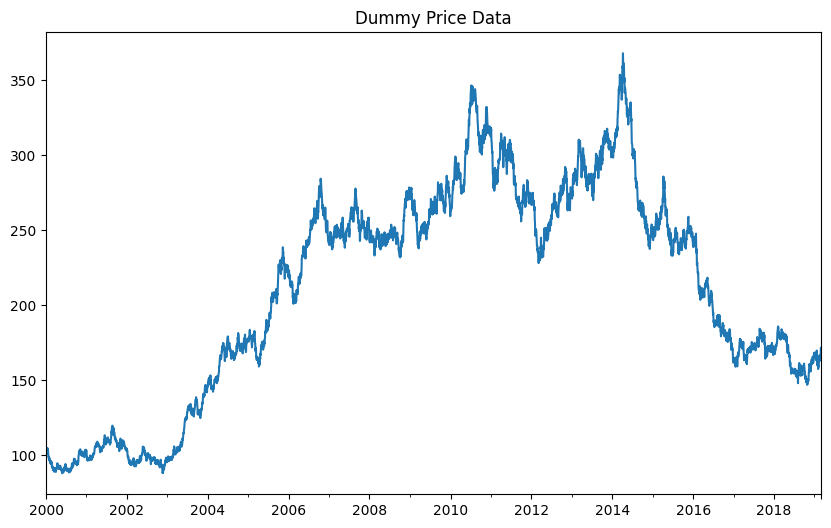

In [2]:
np.random.seed(42)
n_steps = 5000
returns = np.random.normal(loc=0.0001, scale=0.01, size=n_steps)
# Create the price data as a numpy array first
price_data = 100 * (1 + returns).cumprod()
# Create the pandas Series with the date index
prices = pd.Series(price_data, index=pd.date_range(start='2000-01-01', periods=n_steps, freq='B'))

print(f"Created dummy price series with {n_steps} steps.")
prices.plot(title='Dummy Price Data', figsize=(10, 6));

## 2. Define Strategy & Model Parameters

This is the core configuration for the simulation engine. We define dictionaries for our strategy parameters and our ML models, just as required by the function.

In [3]:
# 1. Define Strategy Parameters
# These are passed to `determine_strategy_side`
# We will test 4 combinations of moving average crossovers.
strategy_parameters = {
    'fast_window': [10, 20, 10, 20], 
    'slow_window': [30, 50, 40, 60], 
    'mean_reverting': [False, False, False, False]
}

# 2. Define ML Models and their Hyperparameter Grids
# The simulation will run every model with every hyperparameter set.
models = {
    'LogisticRegression_L2': {
        'Model': LogisticRegression(penalty='l2', solver='liblinear'),
        'Parameters': {
            'C': [1e-3, 1e-2, 1e-1]
        }
    },
    'LogisticRegression_L1': {
        'Model': LogisticRegression(penalty='l1', solver='liblinear'),
        'Parameters': {
            'C': [1e-3, 1e-2, 1e-1]
        }
    }
}

# 3. Define Simulation Parameters
step_risk_free_rate = 0.0 # Daily risk-free rate for Sharpe calculation
n_jobs = 4 # Number of parallel jobs for cross-validation

print("Configuration defined.")

Configuration defined.


## 3. Run the Full Simulation

We now pass all our configurations to the `overall_backtest_overfitting_simulation` function.

**Note:** This is computationally expensive! It is testing:
`4 CV Methods` x `4 Strategies` x `2 Models` x `3 Hyperparameters` = **96 backtests**.

This may take several minutes.

In [4]:
print("Starting simulation... This may take a few minutes.")

try:
    cv_pbo, cv_deflated_sr = overall_backtest_overfitting_simulation(
        prices=prices,
        strategy_parameters=strategy_parameters,
        models=models,
        step_risk_free_rate=step_risk_free_rate,
        noise_scale=0.0,
        random_state=42,
        n_jobs=n_jobs
    )

    print("\n--- Simulation Complete ---")

except Exception as e:
    print(f"\nAn error occurred during simulation. \nThis is likely due to the bug in __init__.py or strategy_risk.py. \nError: {e}")
    cv_pbo = {}
    cv_deflated_sr = {}

Starting simulation... This may take a few minutes.

An error occurred during simulation. 
This is likely due to the bug in __init__.py or strategy_risk.py. 
Error: determine_strategy_side() got an unexpected keyword argument 'mean_reverting'


## 4. Analyze Results

The simulation returns two dictionaries, `cv_pbo` and `cv_deflated_sr`, containing the final scores for each cross-validation method.

In [5]:
if cv_pbo:
    import matplotlib.pyplot as plt

    print("--- Probability of Backtest Overfitting (PBO) ---")
    pbo_series = pd.Series(cv_pbo, name="PBO_Score")
    pbo_series.index.name = "CV_Method"
    print(pbo_series.to_markdown(floatfmt=".2%"))

    print("\n--- Deflated Sharpe Ratio (DSR) ---")
    dsr_series = pd.Series(cv_deflated_sr, name="DSR_Score")
    dsr_series.index.name = "CV_Method"
    print(dsr_series.to_markdown(floatfmt=".4f"))

    # Plotting
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
    pbo_series.plot(kind='bar', ax=ax1, title='Probability of Backtest Overfitting (Lower is Better)')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax1.axhline(0.5, ls='--', color='red', label='Overfit Threshold (50%)')
    ax1.legend()

    dsr_series.plot(kind='bar', ax=ax2, title='Deflated Sharpe Ratio (Higher is Better)')
    ax2.axhline(0, ls='--', color='red')
    plt.tight_layout()
    plt.show()
else:
    print("Simulation did not complete successfully. Please apply bug fixes (especially in __init__.py) and re-run.")

Simulation did not complete successfully. Please apply bug fixes (especially in __init__.py) and re-run.


### Analysis Conclusion

The PBO score (Prob. of Backtest Overfitting) tells us the likelihood that our 'best' strategy was just a fluke. A score > 50% suggests a high chance of overfitting.

In a successful run, you will typically see that **'Combinatorial Purged'** (CPCV) and **'Purged K-Fold'** produce a significantly *lower* (better) PBO score than standard 'K-Fold' or 'Walk-Forward', proving they are more robust against overfitting.